Import required libaries

In [1]:

import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

Then we insert all the required connection properties

In [2]:
conn = pyodbc.connect('Driver={ODBC Driver 13 for SQL Server};' # This is what server type we are connecting to
                      'Server=DESKTOP-3G2D9G9;' # This is the location and name of the server, same as what we use to connect using SSMS
                      'Database=AdventureWorks2019;' # This is which database we are connecting to within the selected server
                      'Trusted_Connection=yes;') # This allows us to forgo entering a trusted key or password because we are the admin of this computer and the...
                    # ... database has been configured to allow this user when we set it up. 

Now we create the cursor

In [3]:
cursor = conn.cursor()

Here we define what query we want executed in the database

In [4]:
#query = 'SELECT JobTitle, SickLeaveHours from HumanResources.Employee order by JobTitle'
query = '''WITH LatestDepartment AS (
    SELECT
        EDH.BusinessEntityID,
        MAX(EDH.DepartmentID) AS LatestDepartmentID
    FROM
        HumanResources.EmployeeDepartmentHistory AS EDH
    WHERE
        EDH.EndDate IS NULL
    GROUP BY
        EDH.BusinessEntityID
)

SELECT
    D.Name AS DepartmentName,
    E.JobTitle,
    E.SickLeaveHours,
    E.OrganizationLevel,
    YEAR(GETDATE()) - YEAR(E.BirthDate) AS Age,
    YEAR(GETDATE()) - YEAR(E.HireDate) AS YearsOfExperience
FROM
    HumanResources.Employee AS E
INNER JOIN
    LatestDepartment AS LD ON E.BusinessEntityID = LD.BusinessEntityID
INNER JOIN
    HumanResources.Department AS D ON LD.LatestDepartmentID = D.DepartmentID
ORDER BY
    E.OrganizationLevel Desc;
'''





Here we assign the resulting table returned from the database as a variable 'salesdata'. 
This is also where our connection actually runs using the defined properties and query above

In [5]:
df = pd.read_sql(query, conn)




C:\Users\Generation UK&I\AppData\Local\Temp\ipykernel_10344\265773493.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Let's get a preview of what our data looks like:

In [6]:
di = df.groupby('DepartmentName')['SickLeaveHours'].apply(list).to_dict()
di_f = df.groupby('OrganizationLevel')['SickLeaveHours'].apply(list).to_dict()


Lastly i create a scatter plot using two of the fields returned from the database

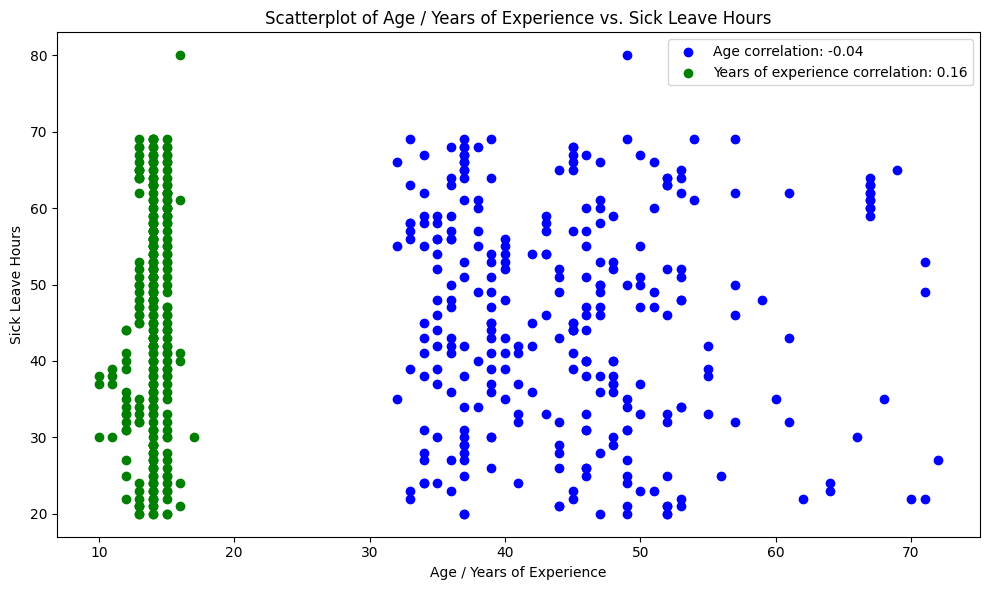

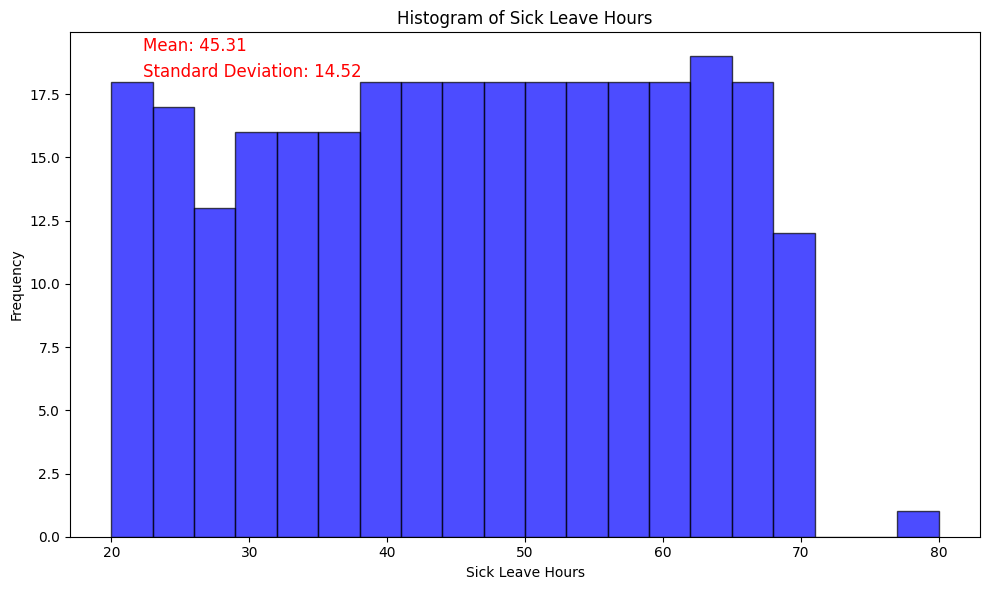

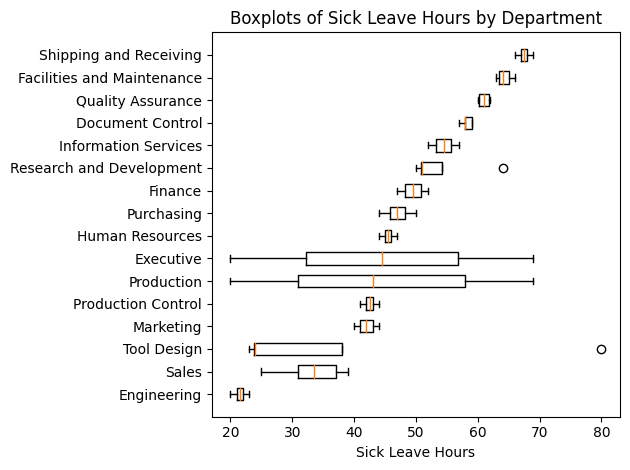

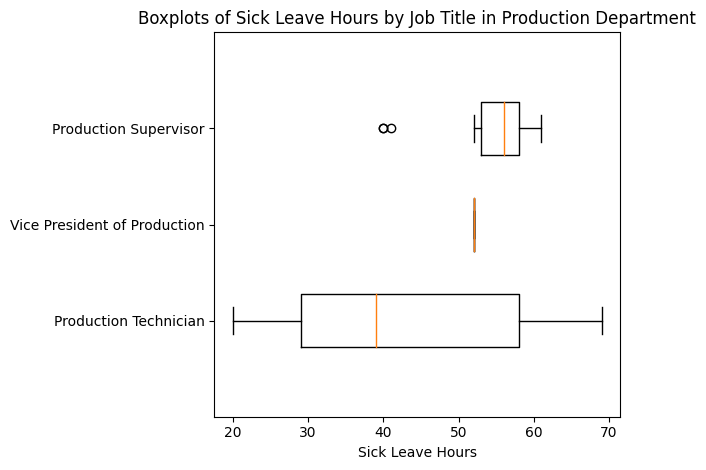

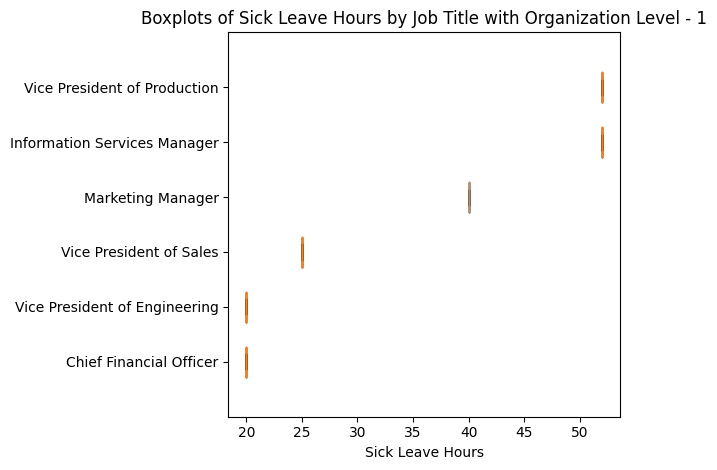

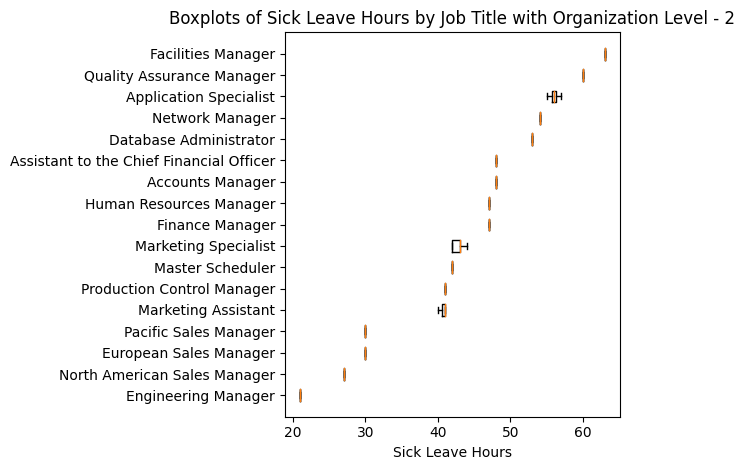

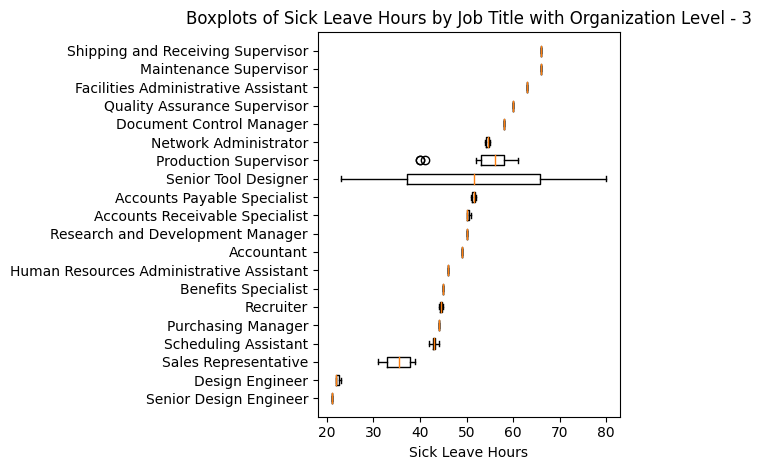

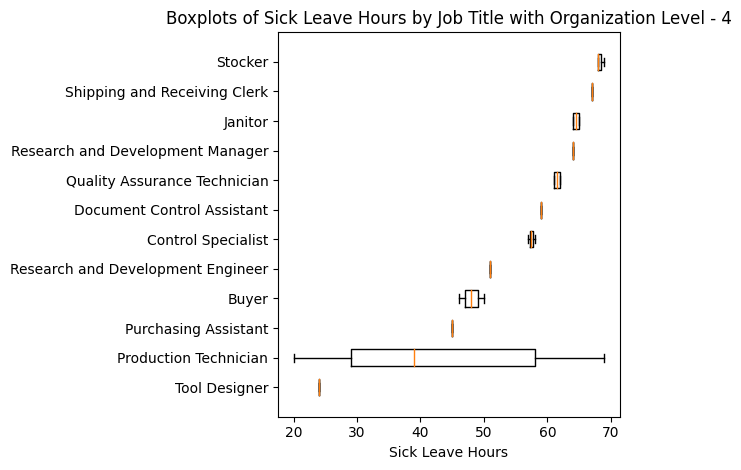

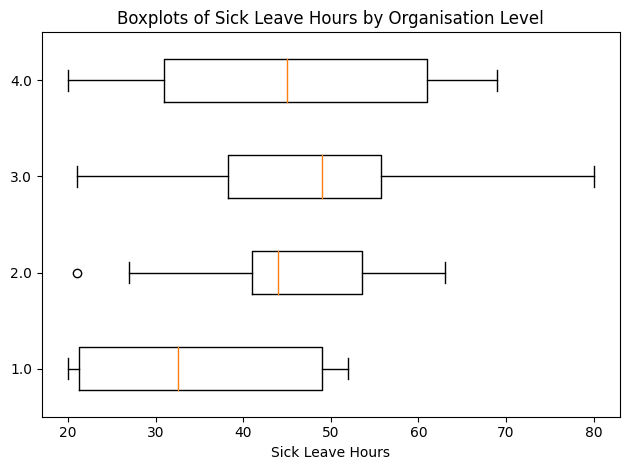

In [7]:

age_correlation = df['Age'].corr(df['SickLeaveHours'])
exp_correlation = df['YearsOfExperience'].corr(df['SickLeaveHours'])

# Create a scatterplot
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size
plt.scatter(df['Age'], df['SickLeaveHours'], label=f'Age correlation: {age_correlation:.2f}', color='blue')
plt.scatter(df['YearsOfExperience'], df['SickLeaveHours'], label=f'Years of experience correlation: {exp_correlation:.2f}', color='green')

# Add labels and title
plt.xlabel('Age / Years of Experience')
plt.ylabel('Sick Leave Hours')
plt.title('Scatterplot of Age / Years of Experience vs. Sick Leave Hours')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6)) 
plt.hist(df['SickLeaveHours'], bins=20, edgecolor='k', alpha=0.7, color='blue')

# Calculate mean and standard deviation
mean_value = np.mean(df['SickLeaveHours'])
std_deviation = np.std(df['SickLeaveHours'])

# Add mean and standard deviation as text
plt.text(mean_value -23, 19.2, f'Mean: {mean_value:.2f}', fontsize=12, color='red')
plt.text(mean_value - 23, 18.2, f'Standard Deviation: {std_deviation:.2f}', fontsize=12, color='red')

# Add labels and title
plt.xlabel('Sick Leave Hours')
plt.ylabel('Frequency')
plt.title('Histogram of Sick Leave Hours')

# Show the plot
plt.tight_layout()
plt.show()

means = [np.mean(values) for values in di.values()]
sorted_means, sorted_labels = zip(*sorted(zip(means, di.keys())))
positions = np.arange(len(sorted_means))*10
plt.boxplot([di[label] for label in sorted_labels], vert = False, positions=positions, widths=5.5)
plt.xlabel('Sick Leave Hours')
plt.ylim(-10,len(sorted_labels)*10)
plt.yticks(positions, sorted_labels, rotation=0)
plt.title('Boxplots of Sick Leave Hours by Department')
plt.tight_layout()

plt.show()


filtered_job_titles = df[df['DepartmentName'] == 'Production'].groupby('JobTitle')['SickLeaveHours'].median()
di_j1 = df[df['JobTitle'].isin(filtered_job_titles.index)].groupby('JobTitle')['SickLeaveHours'].apply(list).to_dict()

common_prefix_supervisor = 'Production Supervisor'
common_prefix_technician = 'Production Technician'

# Create a new dictionary to store the updated values
updated_di_j1 = {}

for key, value in di_j1.items():
    if key.startswith(common_prefix_supervisor):
        new_key = common_prefix_supervisor
    elif key.startswith(common_prefix_technician):
        new_key = common_prefix_technician
    else:
        new_key = key

    # If the new_key already exists in updated_di_j1, extend the values, else create a new entry
    if new_key in updated_di_j1:
        updated_di_j1[new_key].extend(value)
    else:
        updated_di_j1[new_key] = value

# Update di_j1 with the modified dictionary
di_j1 = updated_di_j1


means_j1 = [np.mean(values) for values in di_j1.values()]
sorted_means_j1, sorted_labels_j1 = zip(*sorted(zip(means_j1, di_j1.keys())))
positions_j1 = np.arange(len(sorted_means_j1)) * 10
plt.boxplot([di_j1[label] for label in sorted_labels_j1], vert=False, positions=positions_j1, widths=5.5)
plt.xlabel('Sick Leave Hours')
plt.ylim(-10, len(sorted_labels_j1) * 10)
plt.yticks(positions_j1, sorted_labels_j1, rotation=0)
plt.title('Boxplots of Sick Leave Hours by Job Title in Production Department')
plt.tight_layout()
plt.show()

# Create a dictionary to store filtered data for different organization levels
organization_levels = [1, 2, 3, 4]
boxplots_data = {}

for org_level in organization_levels:
    # Filter data based on organization level
    filtered_data = df[df['OrganizationLevel'] == org_level]

    # Calculate median Sick Leave Hours for each Job Title within the filtered data
    filtered_job_titles = filtered_data.groupby('JobTitle')['SickLeaveHours'].median()

    # Create a dictionary for the filtered data
    di = filtered_data[filtered_data['JobTitle'].isin(filtered_job_titles.index)].groupby('JobTitle')['SickLeaveHours'].apply(list).to_dict()

    # Apply the common prefix logic
    common_prefix_supervisor = 'Production Supervisor'
    common_prefix_technician = 'Production Technician'

    updated_di = {}
    
    for key, value in di.items():
        if key.startswith(common_prefix_supervisor):
            new_key = common_prefix_supervisor
        elif key.startswith(common_prefix_technician):
            new_key = common_prefix_technician
        else:
            new_key = key

        if new_key in updated_di:
            updated_di[new_key].extend(value)
        else:
            updated_di[new_key] = value

    # Update the dictionary for the specific organization level
    boxplots_data[org_level] = updated_di

# Create and display boxplots for different organization levels
for org_level, di_j1 in boxplots_data.items():
    means_j1 = [np.mean(values) for values in di_j1.values()]
    sorted_means_j1, sorted_labels_j1 = zip(*sorted(zip(means_j1, di_j1.keys())))
    positions_j1 = np.arange(len(sorted_means_j1)) * 10
    plt.boxplot([di_j1[label] for label in sorted_labels_j1], vert=False, positions=positions_j1, widths=5.5)
    plt.xlabel('Sick Leave Hours')
    plt.ylim(-10, len(sorted_labels_j1) * 10)
    plt.yticks(positions_j1, sorted_labels_j1, rotation=0)
    plt.title(f'Boxplots of Sick Leave Hours by Job Title with Organization Level - {org_level}')
    plt.tight_layout()
    plt.show()

plt.boxplot(list(di_f.values()), labels = list(di_f.keys()), vert=False)    

plt.xlabel('Sick Leave Hours')
plt.title('Boxplots of Sick Leave Hours by Organisation Level')
plt.tight_layout()
plt.show()


Now you can reverse engineer the code I have shown you above to create your own projects